# COVID Forecasting: SIR Model and Regression

Notebook derived from Patrick Sánchez's [kernel](https://www.kaggle.com/saga21/covid-global-forecast-sir-model-ml-regressions/notebook) as part of [COVID19 Global Forecasting](https://www.kaggle.com/c/covid19-global-forecasting-week-1).

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import glob

# ML libraries
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

In [2]:
# Path to input csvs
DATA_DIR = "csse_covid_19_daily_reports/"

In [3]:
def build_aggregate_df():

    agg_df = None

    for fn in glob.glob(DATA_DIR + "*.csv"):
        df = pd.read_csv(fn)
        df["Date"] = fn.split("/")[-1].split(".csv")[0]
        df.rename(columns={
            "Country/Region": "Country_Region", 
            "Province/State": "Province_State",
            "Deaths": "Fatalities",
            "Confirmed": "ConfirmedCases"
        }, inplace=True)
        if agg_df is None:
            agg_df = df
        else:
            agg_df = agg_df.append(df, ignore_index=True)

    # Type Conversions
    agg_df["Date"] = pd.to_datetime(agg_df["Date"])
    agg_df.sort_values("Date", inplace=True)
    
    # Handle nulls
    agg_df["Province_State"].fillna("Other", inplace=True)
    
    # Column Selection
    cols = ["Date", "Province_State", "Country_Region", "Fatalities", "ConfirmedCases"]
    
    # Aggregate at date, country, state grain
    agg_df = agg_df[cols].groupby(by=["Date", "Province_State", "Country_Region"]).sum()
    agg_df = agg_df.reset_index()
    agg_df = agg_df[cols]
    

    print("Num Rows:", agg_df.shape[0])
    print("Total Dates:", agg_df["Date"].unique().shape[0])
    print("Min Date:", agg_df["Date"].min())
    print("Max Date:", agg_df["Date"].max())
    
    return agg_df

train = build_aggregate_df()

train.head()

Num Rows: 11299
Total Dates: 72
Min Date: 2020-01-22 00:00:00
Max Date: 2020-04-02 00:00:00


,Date,Province_State,Country_Region,Fatalities,ConfirmedCases
0,2020-01-22,Anhui,Mainland China,0.0,1.0
1,2020-01-22,Beijing,Mainland China,0.0,14.0
2,2020-01-22,Chongqing,Mainland China,0.0,6.0
3,2020-01-22,Fujian,Mainland China,0.0,1.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0


Text(0.5, 0, 'Date')

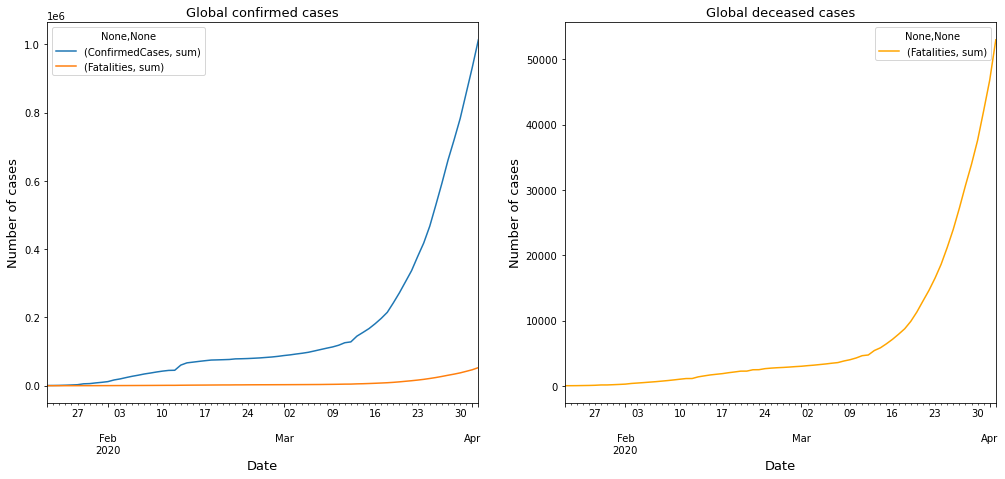

In [4]:
confirmed_total_date = train.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_total_date = train.groupby(['Date']).agg({'Fatalities':['sum']})
total_date = confirmed_total_date.join(fatalities_total_date)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
total_date.plot(ax=ax1)
ax1.set_title("Global confirmed cases", size=13)
ax1.set_ylabel("Number of cases", size=13)
ax1.set_xlabel("Date", size=13)
fatalities_total_date.plot(ax=ax2, color='orange')
ax2.set_title("Global deceased cases", size=13)
ax2.set_ylabel("Number of cases", size=13)
ax2.set_xlabel("Date", size=13)

# SIR Model

SIR considers a population that belongs to one of the following states:
1. **Susceptible (S)**. The individual hasn't contracted the disease, but she can be infected due to transmisison from infected people
2. **Infected (I)**. This person has contracted the disease
3. **Recovered/Deceased (R)**. The disease may lead to one of two destinies: either the person survives, hence developing inmunity to the disease, or the person is deceased. 

<img src="https://www.lewuathe.com/assets/img/posts/2020-03-11-covid-19-dynamics-with-sir-model/sir.png" width="500px">
Image by Kai Sasaki


$$ {dS \over dt} = - {\beta S I \over N} $$

$$ {dI \over dt} = {\beta S I \over N} - \gamma I$$

$$ {dR \over dt} = \gamma I$$

Where $\beta$ is the contagion rate of the pathogen and $\gamma$ is the recovery rate.

## Implementing the SIR Model

In [5]:
# Susceptible equation
def fa(N, a, b, beta):
    fa = -beta*a*b
    return fa

# Infected equation
def fb(N, a, b, beta, gamma):
    fb = beta*a*b - gamma*b
    return fb

# Recovered/deceased equation
def fc(N, b, gamma):
    fc = gamma*b
    return fc

In [6]:
# Runge-Kutta method of 4rth order for 3 dimensions (susceptible a, infected b and recovered r)
def rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs):
    a1 = fa(N, a, b, beta)*hs
    b1 = fb(N, a, b, beta, gamma)*hs
    c1 = fc(N, b, gamma)*hs
    ak = a + a1*0.5
    bk = b + b1*0.5
    ck = c + c1*0.5
    a2 = fa(N, ak, bk, beta)*hs
    b2 = fb(N, ak, bk, beta, gamma)*hs
    c2 = fc(N, bk, gamma)*hs
    ak = a + a2*0.5
    bk = b + b2*0.5
    ck = c + c2*0.5
    a3 = fa(N, ak, bk, beta)*hs
    b3 = fb(N, ak, bk, beta, gamma)*hs
    c3 = fc(N, bk, gamma)*hs
    ak = a + a3
    bk = b + b3
    ck = c + c3
    a4 = fa(N, ak, bk, beta)*hs
    b4 = fb(N, ak, bk, beta, gamma)*hs
    c4 = fc(N, bk, gamma)*hs
    a = a + (a1 + 2*(a2 + a3) + a4)/6
    b = b + (b1 + 2*(b2 + b3) + b4)/6
    c = c + (c1 + 2*(c2 + c3) + c4)/6
    return a, b, c

In [7]:
def SIR(N, b0, beta, gamma, hs):
    
    """
    N = total number of population
    beta = transition rate S->I
    gamma = transition rate I->R
    k =  denotes the constant degree distribution of the network (average value for networks in which 
    the probability of finding a node with a different connectivity decays exponentially fast
    hs = jump step of the numerical integration
    """
    
    # Initial condition
    a = float(N-1)/N -b0
    b = float(1)/N +b0
    c = 0.

    sus, inf, rec= [],[],[]
    for i in range(10000): # Run for a certain number of time-steps
        sus.append(a)
        inf.append(b)
        rec.append(c)
        a,b,c = rK4(N, a, b, c, fa, fb, fc, beta, gamma, hs)

    return sus, inf, rec

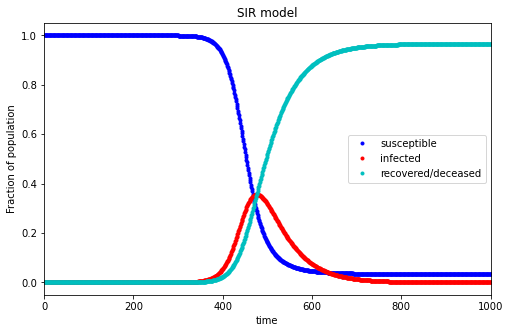

In [8]:
# Parameters of the model
N = 7800*(10**6)
b0 = 0
beta = 0.7
gamma = 0.2
hs = 0.1

sus, inf, rec = SIR(N, b0, beta, gamma, hs)

f = plt.figure(figsize=(8,5)) 
plt.plot(sus, 'b.', label='susceptible');
plt.plot(inf, 'r.', label='infected');
plt.plot(rec, 'c.', label='recovered/deceased');
plt.title("SIR model")
plt.xlabel("time", fontsize=10);
plt.ylabel("Fraction of population", fontsize=10);
plt.legend(loc='best')
plt.xlim(0,1000)
plt.show()

## Fit SIR Parameters to Real Data

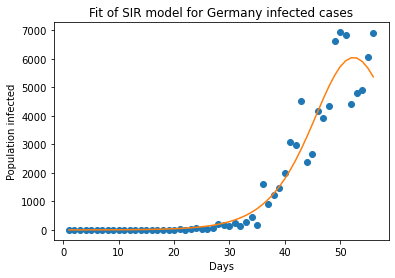

Optimal parameters: beta = 16.288865303311987  and gamma =  16.092518343443047


In [9]:
population = float(82900000)
country_df = pd.DataFrame()
country_df['ConfirmedCases'] = train.loc[train['Country_Region']=='Germany'].ConfirmedCases.diff().fillna(0)
country_df = country_df[10:]
country_df['day_count'] = list(range(1,len(country_df)+1))

ydata = [i for i in country_df.ConfirmedCases]
xdata = country_df.day_count
ydata = np.array(ydata, dtype=float)
xdata = np.array(xdata, dtype=float)

N = population
inf0 = ydata[0]
sus0 = N - inf0
rec0 = 0.0

def sir_model(y, x, beta, gamma):
    sus = -beta * y[0] * y[1] / N
    rec = gamma * y[1]
    inf = -(sus + rec)
    return sus, inf, rec

def fit_odeint(x, beta, gamma):
    return integrate.odeint(sir_model, (sus0, inf0, rec0), x, args=(beta, gamma))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, xdata, ydata)
fitted = fit_odeint(xdata, *popt)

plt.plot(xdata, ydata, 'o')
plt.plot(xdata, fitted)
plt.title("Fit of SIR model for Germany infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

## Compute Lags and Trends

Enriching a dataset is key to obtain good results. In this case we will apply 2 different transformations:

**Lag**. Lags are a way to compute the previous value of a column, so that the lag 1 for ConfirmedCases would inform the this column from the previous day. The lag 3 of a feature X is simply:
$$X_{lag3}(t) = X(t-3)$$


**Trend**. Transformig a column into its trend gives the natural tendency of this column, which is different from the raw value. The definition of trend I will apply is: 
$$Trend_{X} = {X(t) - X(t-1) \over X(t-1)}$$

The backlog of lags I'll apply is 14 days, while for trends is 7 days.  For ConfirmedCases and Fatalities:

In [10]:
all_data = train.copy()
all_data['Date'] = pd.to_datetime(all_data['Date'])

# Create date columns
le = preprocessing.LabelEncoder()
all_data['Day_num'] = le.fit_transform(all_data.Date)
all_data['Day'] = all_data['Date'].dt.day
all_data['Month'] = all_data['Date'].dt.month
all_data['Year'] = all_data['Date'].dt.year

In [11]:
def calculate_trend(df, lag_list, column):
    for lag in lag_list:
        trend_column_lag = "Trend_" + column + "_" + str(lag)
        df[trend_column_lag] = (df[column]-df[column].shift(lag, fill_value=-999))/df[column].shift(lag, fill_value=0)
    return df


def calculate_lag(df, lag_list, column):
    for lag in lag_list:
        column_lag = column + "_" + str(lag)
        df[column_lag] = df[column].shift(lag, fill_value=0)
    return df

ts = time.time()
all_data = calculate_lag(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_lag(all_data, range(1,7), 'Fatalities')
all_data = calculate_trend(all_data, range(1,7), 'ConfirmedCases')
all_data = calculate_trend(all_data, range(1,7), 'Fatalities')
all_data.replace([np.inf, -np.inf], 0, inplace=True)
all_data.fillna(0, inplace=True)
print("Time spent: ", time.time()-ts)

Time spent:  0.06031966209411621


In [12]:
all_data[all_data['Country_Region']=='Spain'][['Province_State', 'Country_Region', 'Date',
       'ConfirmedCases', 'Fatalities', 'Day_num', 'ConfirmedCases_1',
       'ConfirmedCases_2', 'ConfirmedCases_3', 'Fatalities_1', 'Fatalities_2',
       'Fatalities_3']]

,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,Day_num,ConfirmedCases_1,ConfirmedCases_2,ConfirmedCases_3,Fatalities_1,Fatalities_2,Fatalities_3
535,Other,Spain,2020-02-01,1.0,0.0,10,12.0,16.0,2.0,0.0,0.0,0.0
602,Other,Spain,2020-02-02,1.0,0.0,11,15.0,18.0,2.0,0.0,0.0,0.0
669,Other,Spain,2020-02-03,1.0,0.0,12,15.0,18.0,2.0,0.0,0.0,0.0
738,Other,Spain,2020-02-04,1.0,0.0,13,16.0,24.0,2.0,0.0,0.0,0.0
809,Other,Spain,2020-02-05,1.0,0.0,14,19.0,28.0,2.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9978,Other,Spain,2020-03-29,80110.0,6803.0,67,1280.0,3.0,730.0,2.0,0.0,11.0
10290,Other,Spain,2020-03-30,87956.0,7716.0,68,1326.0,3.0,756.0,3.0,0.0,11.0
10603,Other,Spain,2020-03-31,95923.0,8464.0,69,1353.0,5.0,802.0,5.0,0.0,15.0
10916,Other,Spain,2020-04-01,104118.0,9387.0,70,1380.0,5.0,841.0,5.0,0.0,15.0


## Add Country Details

Variables like the total population of a country, the average age of citizens or the fraction of peoople living in cities may strongly impact on the COVID-19 transmission behavior. 

In [13]:
# Load countries data file
world_population = pd.read_csv("population_by_country_2020.csv")

# Select desired columns and rename some of them
world_population = world_population[['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)', 'Land Area (Km²)', 'Med. Age', 'Urban Pop %']]
world_population.columns = ['Country (or dependency)', 'Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']

# Replace United States by US
world_population.loc[world_population['Country (or dependency)']=='United States', 'Country (or dependency)'] = 'US'

# Remove the % character from Urban Pop values
world_population['Urban Pop'] = world_population['Urban Pop'].str.rstrip('%')

# Replace Urban Pop and Med Age "N.A" by their respective modes, then transform to int
world_population.loc[world_population['Urban Pop']=='N.A.', 'Urban Pop'] = int(world_population.loc[world_population['Urban Pop']!='N.A.', 'Urban Pop'].mode()[0])
world_population['Urban Pop'] = world_population['Urban Pop'].astype('int16')
world_population.loc[world_population['Med Age']=='N.A.', 'Med Age'] = int(world_population.loc[world_population['Med Age']!='N.A.', 'Med Age'].mode()[0])
world_population['Med Age'] = world_population['Med Age'].astype('int16')

print("Cleaned country details dataset")
display(world_population)

# Now join the dataset to our previous DataFrame and clean missings (not match in left join)- label encode cities
print("Joined dataset")
all_data = all_data.merge(world_population, left_on='Country_Region', right_on='Country (or dependency)', how='left')
all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']] = all_data[['Population (2020)', 'Density', 'Land Area', 'Med Age', 'Urban Pop']].fillna(0)
display(all_data)

print("Encoded dataset")
# Label encode countries and provinces. Save dictionary for exploration purposes
all_data.drop('Country (or dependency)', inplace=True, axis=1)
all_data['Country_Region'] = le.fit_transform(all_data['Country_Region'].astype(str))
number_c = all_data['Country_Region']
countries = le.inverse_transform(all_data['Country_Region'])
country_dict = dict(zip(countries, number_c)) 
all_data['Province_State'] = le.fit_transform(all_data['Province_State'].astype(str))
number_p = all_data['Province_State']
province = le.inverse_transform(all_data['Province_State'])
province_dict = dict(zip(province, number_p)) 

display(all_data)

Cleaned country details dataset


,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,China,1439323776,153,9388211,38,61
1,India,1380004385,464,2973190,28,35
2,US,331002651,36,9147420,38,83
3,Indonesia,273523615,151,1811570,30,56
4,Pakistan,220892340,287,770880,23,35
...,...,...,...,...,...,...
230,Montserrat,4992,50,100,19,10
231,Falkland Islands,3480,0,12170,19,66
232,Niue,1626,6,260,19,46
233,Tokelau,1357,136,10,19,0


Joined dataset


,Date,Province_State,Country_Region,Fatalities,ConfirmedCases,Day_num,Day,Month,Year,ConfirmedCases_1,...,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Country (or dependency),Population (2020),Density,Land Area,Med Age,Urban Pop
0,2020-01-22,Anhui,Mainland China,0.0,1.0,0,22,1,2020,0.0,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000e+00,0.0,0.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,0.0,14.0,0,22,1,2020,1.0,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000e+00,0.0,0.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,0.0,6.0,0,22,1,2020,14.0,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000e+00,0.0,0.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,0.0,1.0,0,22,1,2020,6.0,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000e+00,0.0,0.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0,22,1,2020,1.0,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000e+00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11294,2020-04-02,Wyoming,US,0.0,150.0,71,2,4,2020,1748.0,...,-1.000000,-1.000000,-1.000000,0.000000,US,3.310027e+08,36.0,9147420.0,38.0,83.0
11295,2020-04-02,Xinjiang,China,3.0,76.0,71,2,4,2020,150.0,...,0.500000,0.500000,-0.988930,-0.926829,China,1.439324e+09,153.0,9388211.0,38.0,61.0
11296,2020-04-02,Yukon,Canada,0.0,6.0,71,2,4,2020,76.0,...,-1.000000,-1.000000,-1.000000,-1.000000,Canada,3.774215e+07,4.0,9093510.0,41.0,81.0
11297,2020-04-02,Yunnan,China,2.0,183.0,71,2,4,2020,6.0,...,0.000000,-0.947368,0.000000,0.000000,China,1.439324e+09,153.0,9388211.0,38.0,61.0


Encoded dataset


,Date,Province_State,Country_Region,Fatalities,ConfirmedCases,Day_num,Day,Month,Year,ConfirmedCases_1,...,Trend_Fatalities_2,Trend_Fatalities_3,Trend_Fatalities_4,Trend_Fatalities_5,Trend_Fatalities_6,Population (2020),Density,Land Area,Med Age,Urban Pop
0,2020-01-22,8,129,0.0,1.0,0,22,1,2020,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
1,2020-01-22,15,129,0.0,14.0,0,22,1,2020,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
2,2020-01-22,37,129,0.0,6.0,0,22,1,2020,14.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
3,2020-01-22,76,129,0.0,1.0,0,22,1,2020,6.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
4,2020-01-22,78,129,0.0,0.0,0,22,1,2020,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11294,2020-04-02,290,216,0.0,150.0,71,2,4,2020,1748.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,3.310027e+08,36.0,9147420.0,38.0,83.0
11295,2020-04-02,291,42,3.0,76.0,71,2,4,2020,150.0,...,-0.921053,0.500000,0.500000,-0.988930,-0.926829,1.439324e+09,153.0,9388211.0,38.0,61.0
11296,2020-04-02,293,35,0.0,6.0,71,2,4,2020,76.0,...,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,3.774215e+07,4.0,9093510.0,41.0,81.0
11297,2020-04-02,294,42,2.0,183.0,71,2,4,2020,6.0,...,-0.333333,0.000000,-0.947368,0.000000,0.000000,1.439324e+09,153.0,9388211.0,38.0,61.0


## Linear Regression for One Country

Text(0, 0.5, 'Log ConfirmedCases')

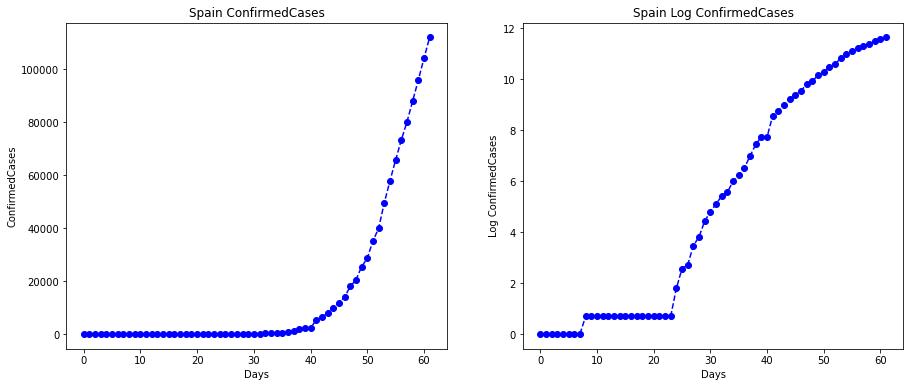

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

y1 = all_data[all_data['Country_Region']==country_dict['Spain']][['ConfirmedCases']]
x1 = range(0, len(y1))
ax1.plot(x1, y1, 'bo--')
ax1.set_title("Spain ConfirmedCases")
ax1.set_xlabel("Days")
ax1.set_ylabel("ConfirmedCases")

y2 = all_data[all_data['Country_Region']==country_dict['Spain']][['ConfirmedCases']].apply(lambda x: np.log(x))
x2 = range(0, len(y2))
ax2.plot(x2, y2, 'bo--')
ax2.set_title("Spain Log ConfirmedCases")
ax2.set_xlabel("Days")
ax2.set_ylabel("Log ConfirmedCases")

In [15]:
# Filter selected features
data = all_data.copy()
features = ['Country_Region', 'Province_State', 'ConfirmedCases', 'Fatalities', 'Day_num', 
            'Density', 'Urban Pop', 'Population (2020)']
data = data[features]

# Apply log transformation to all ConfirmedCases and Fatalities columns, except for trends
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].astype('float64')
data[['ConfirmedCases', 'Fatalities']] = data[['ConfirmedCases', 'Fatalities']].apply(lambda x: np.log1p(x))

# Replace infinites
data.replace([np.inf, -np.inf], 0, inplace=True)


# Split data into train/test
def split_data(data):
    
    # Train set
    x_train = data.drop(['ConfirmedCases', 'Fatalities'], axis=1)
    y_train_1 = data['ConfirmedCases']
    y_train_2 = data['Fatalities']

    # Test set
    x_test = data.drop(['ConfirmedCases', 'Fatalities'], axis=1)
    
    return x_train, y_train_1, y_train_2, x_test


# Linear regression model
def lin_reg(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    
    return regr, y_pred


def get_predictions(df, target1, target2):
    result = {
        "ConfirmedCases": df[target1],
        "Fatalities": df[target2]
    }

    return result

In [16]:
dates_list = pd.date_range('2020-03-01', '2020-04-02').strftime('%Y-%m-%d').tolist()

In [17]:
all_data[all_data.Date=="2020-03-01"][["Date", "Day_num"]]

,Date,Day_num
2818,2020-03-01,39
2819,2020-03-01,39
2820,2020-03-01,39
2821,2020-03-01,39
2822,2020-03-01,39
...,...,...
2938,2020-03-01,39
2939,2020-03-01,39
2940,2020-03-01,39
2941,2020-03-01,39


Results when training with a single country:

* **Spain**

In [18]:
def plot_linreg_basic_country(data, country_name, dates_list, day_start, shift):
    
    data_country = data[data['Country_Region']==country_dict[country_name]]
    data_country = data_country.loc[data_country['Day_num']>=day_start]
    X_train, Y_train_1, Y_train_2, X_test = split_data(data_country)
    model, pred = lin_reg(X_train, Y_train_1, X_test)

    # Create a df with both real cases and predictions
    X_train_check = X_train.copy()
    X_train_check['Target'] = Y_train_1

    predicted_data = X_test.copy()
    predicted_data['Target'] = pred

    # Select predictions
    predicted_data = predicted_data.loc[(predicted_data['Day_num'].isin(list(range(day_start, day_start+len(dates_list)))))].Target
    real_data = train.loc[(train['Country_Region']==country_name) & (train['Date'].isin(dates_list))]['ConfirmedCases']
    dates_list_num = list(range(0,len(dates_list)))

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

    ax1.plot(dates_list_num, np.expm1(predicted_data))
    ax1.plot(dates_list_num, real_data)
    ax1.legend(['Predicted cases', 'Actual cases'], loc='upper left')
    ax1.set_ylabel("Confirmed Cases")

    ax2.plot(dates_list_num, predicted_data)
    ax2.plot(dates_list_num, np.log1p(real_data))
    ax2.legend(['Predicted cases', 'Actual cases'], loc='upper left')
    ax2.set_ylabel("Log Confirmed Cases")

    plt.suptitle(("ConfirmedCases predictions based on Log-Lineal Regression for "+country_name))

* **Italy**

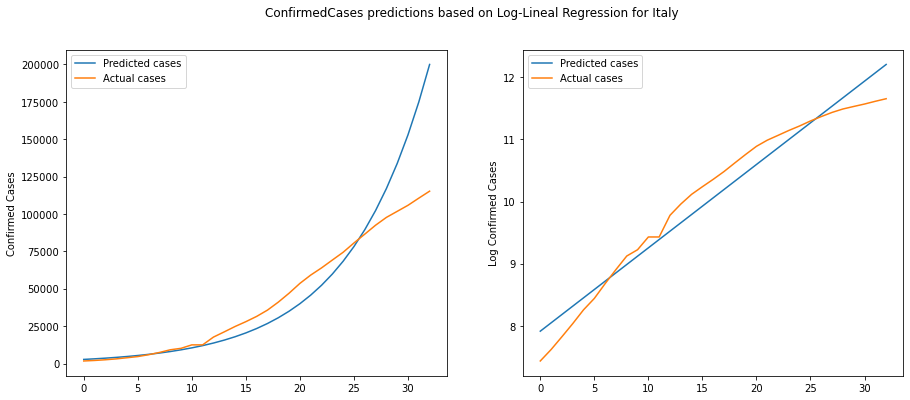

In [19]:
country_name = "Italy"
plot_linreg_basic_country(data, country_name, dates_list, 39, 0)

* **Spain**

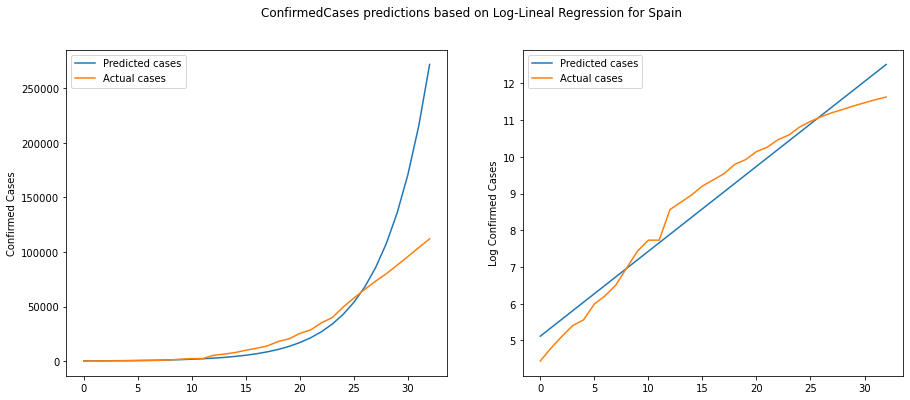

In [20]:
country_name = "Spain"
plot_linreg_basic_country(data, country_name, dates_list, 39, 0)

* **Germany**

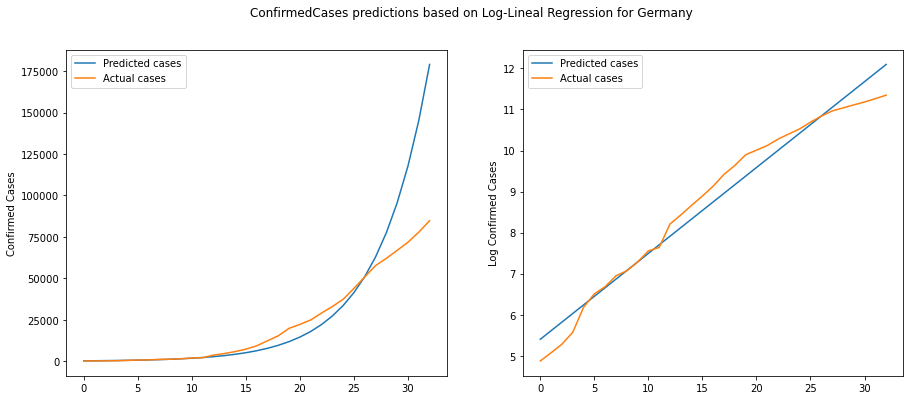

In [21]:
country_name = "Germany"
plot_linreg_basic_country(data, country_name, dates_list, 39, 0)

In [22]:
# Todo: for data with provinces, aggregate first